# Отчет о результатах исследования: «Оптимизация расходов при выплавке стали: предсказание температуры расплавленной стали с помощью машинного обучения»

# Оглавление<a class='anchor' id='TOC'>

#### [План проекта](#roadmap)

#### [1. Код, воспроизводящий подготоку датасетов и демонстирующий общий ход обучения моделей в исследовании](#1)

#### [2. Отчет о ходе исследования](#2)


# План проекта<a class='anchor' id='roadmap'>

По итогам исследовательского анализа данных был сформулирован, предложен и утвержден следующий план:

1. Получить дополнительные сведения о проекте: уточнить задачу и глобальную цель. Определить мотивацию к созданию модели, целевой показатель, метрику качества.
2. Провести исследовательский анализ данных.
3. Подготовить данные для обучения модели: определить оптмальную стратегию объединения данных, провести предобработку данных.
4. Обучить несколько базовых моделей, собрать метрики, выбрать лучшую под решение задачи.
5. Оптимизировать лучшую модель под решение задачи.
6. Подготовить финальный отчет по результатам исследования.

# 1. Код, воспроизводящий подготоку датасетов и демонстирующий общий ход обучения моделей в исследовании<a class='anchor' id='1'>

## 1) загрузим библиотеки

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import datetime
import time
from functools import reduce

[В оглавление](#TOC)

## 2) Подготовим класс для моделей

Ниже код, воспроизводящий ход подготоки датасетов и обучения модели. Для демонстрации избран LGBMRegressor.

In [3]:
class DataExplorer:
    
    def __init__(self, path=''):
        self.df_arc = pd.read_csv(os.path.join(path, 'data_arc.csv'), header=0, parse_dates=[1, 2])
        self.df_bulk_time = pd.read_csv(os.path.join(path, 'data_bulk_time.csv'))
        self.df_bulk = pd.read_csv(os.path.join(path, 'data_bulk.csv'))
        self.df_gas = pd.read_csv(os.path.join(path, 'data_gas.csv'))
        self.df_temp = pd.read_csv(os.path.join(path, 'data_temp.csv'), parse_dates=[1])
        self.df_wire_time = pd.read_csv(os.path.join(path, 'data_wire_time.csv'), parse_dates=True)
        self.df_wire = pd.read_csv(os.path.join(path, 'data_wire.csv'), parse_dates=True)
        
    def histogram(self, data, n_bins, range_start, range_end, grid, cumulative=False, x_label = '', y_label = '', title = ''):
        
        """
        Простая гистограмма
        
        Пример:
        histogram(df, 100, 0, 150, True, 'Количество иксов', 'Количество игриков', 'Заголовок')
        
        data - датасет
        n_bins - количество корзин
        range_start - минимальный икс для корзины
        range_end - максимальный икс для корзины
        grid - рисовать сетку или нет (False / True)
        
        
        histogram(data, n_bins, range_start, range_end, grid, x_label = "", y_label = "", title = "")
        """
        #sns.set()
        
        # Создаем объект - график
        _, ax = plt.subplots()

        # Задаем параметры
        ax.hist(data, bins = n_bins, range = (range_start, range_end), cumulative = cumulative, color = '#4169E1')

        # Добавляем сетку
        if grid == True:
            ax.grid(color='grey', linestyle='-', linewidth=0.5)
        else:
            pass

        # Добавляем медиану, среднее и квартили
        ax.axvline(data.median(),linestyle = '--', color = '#FF1493', label = 'median')
        ax.axvline(data.mean(),linestyle = '--', color = 'orange', label = 'mean')
        ax.axvline(data.quantile(0.1),linestyle = '--', color = 'yellow', label = '1%')
        ax.axvline(data.quantile(0.99),linestyle = '--', color = 'yellow', label = '99%')
        ax.legend()
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        
    
    def basic_dataset(self):
        print('Подготовка датасета с признаками об электродах, сыпучих материалах, проволоке и газе: \n')
        df_bulk_m = self.df_bulk.copy().fillna(0)
        df_wire_m = self.df_wire.copy().fillna(0)
        df_temp_m = self.df_temp.copy()
        df_gas_m = self.df_gas.copy()
        df_arc_m = self.df_arc.copy()
        
        print('1. В данных об электродах создаем признаки: \n\
              - время нагрева, \n\
              - соотношение активной и реактивной мощности, \n\
              - считаем полную мощность (корень из суммы квадратов активной и реактивной мощностей), \n\
              - сообщенную энергию.')
        df_arc_m['heat_time_min'] = (df_arc_m['Конец нагрева дугой'] - df_arc_m['Начало нагрева дугой'])
        df_arc_m['heat_time_sec'] = df_arc_m['heat_time_min'].astype('timedelta64[s]')
        df_arc_m['power_ratio'] = df_arc_m['Активная мощность'] / df_arc_m['Реактивная мощность']
        df_arc_m['full_power'] = np.sqrt(df_arc_m['Активная мощность']**2 + df_arc_m['Реактивная мощность']**2)
        df_arc_m['energy'] = df_arc_m['full_power'] * df_arc_m['heat_time_sec']
        print('Полученная размерность: ', df_arc_m.shape)
        
        df_arc_grouped = df_arc_m.groupby('key').agg({'Активная мощность' : 'mean',
                                                      'Реактивная мощность' : 'mean',
                                                      'heat_time_sec' : 'mean',
                                                      'power_ratio' : 'mean',
                                                      'full_power' : 'mean',
                                                      'energy' : 'mean',
                                                      'key' : 'size'})
        df_arc_grouped.columns = ['active_power', 'reactive_power', 'heat_time_sec', 'power_ratio', 'full_power', 'energy', 'heat_times']
        
        print('\n 2. Сгруппировали данные об электродах по ключу. Переименовали столбцы. Полученная размерность: ', df_arc_grouped.shape)
        print('------------------------------------------------------------------------------------------------------- \n') 
        return df_arc_grouped
    
    def time_features(self):
        print('Подготовка датасета с температурой: \n')
        df_temp_m = self.df_temp.dropna()
        print('1. Отбросили строки без замеров температуры. Полученная размерность: ', df_temp_m.shape)
        
        df_temp_m = df_temp_m[df_temp_m.duplicated('key', keep=False) == True]
        print('2. Оставили в датасете с замерами температур наблюдения,',\
              'в которых каждой партии соответствует хотя бы еще один замер.',\
              'Полученная размерность: ', df_temp_m.shape)
        for lag in range(1, 5 + 1):
            df_temp_m['lag_{}'.format(lag)] = df_temp_m['Температура'].shift(lag)
        df_temp_m = df_temp_m.fillna(0)
        print('3. Создали лаг в пять шагов. Образовавшиеся пропуски заполнили плейсхолдером - 0.',\
              'Полученная размерность: ', df_temp_m.shape)   
        
        df_temp_pivot = df_temp_m.groupby('key').agg({'Температура' : [lambda x: x.iloc[-1], lambda x: x.iloc[0]],
                                      'lag_1' : [lambda x: x.iloc[-1]],
                                      'lag_2' : [lambda x: x.iloc[-1]],
                                      'lag_3' : [lambda x: x.iloc[-1]],
                                      'lag_4' : [lambda x: x.iloc[-1]]})
        print('4. Сгруппировали данные по ключу-партии. Полученная размерность: ', df_temp_pivot.shape)
        
        df_temp_pivot['temp_diff'] = df_temp_pivot['lag_4'] - df_temp_pivot['lag_1']
        df_temp_pivot['temp_mean'] = (df_temp_pivot['lag_4'] + df_temp_pivot['lag_3'] + df_temp_pivot['lag_2'] + df_temp_pivot['lag_1']) / 4
        print('5. Создали признаки - разница между предпоследним и первым замером температуры, среднюю температуру (не включая целевую).',\
              'Полученная размерность: ', df_temp_pivot.shape)
        
        df_temp_pivot.reset_index(inplace=True)
        df_temp_pivot.columns = ['key', 'temp', 'first_temp', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'temp_diff', 'temp_mean']
        print('6. Сбросили индекс, переименовали столбцы. Итоговая размерность данных с замером температуры: ', df_temp_pivot.shape)
        print('------------------------------------------------------------------------------------------------------- \n')
        return df_temp_pivot
    
    def final_dataset(self):
        df_merged = self.basic_dataset()
        df_temp_pivot = self.time_features()
        
        df_final = df_merged.merge(df_temp_pivot, on='key')
        df_final.dropna(inplace=True)
        
        columns = ['temp', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'temp_diff', 'temp_mean']
        
        for col in columns:
            df_final[col] = df_final[col].astype(int)
        print('Итоговый датасет: объединили по ключу, переименовали столбцы. Строки, где из-за расхождениях в партиях пропуски - отбросили')
        print('Размер полученного датасета: ', df_final.shape)
        
        return df_final
    
    class Reporter():

        def __init__(self, data, target, features_dict, models, folds=5, score=mean_absolute_error, 
                     scoring='neg_mean_absolute_error', random_state=42):

            """
            data - dataset
            target - 'целевой признак'
            регуляризоват - {словарь признаков}
            models - [список моделей]
            """

            self.final_report = None
            self.best_estimator = []
            self.predictions = []
            self.data = data
            self.target = target
            self.models = models
            self.score = score
            self.scoring = scoring
            self.random_state = random_state
            self.features_dict = features_dict
            self.folds = folds

        def grid_search(self, model, param_grid, cv, x, y):

            """
            Поиск по сетке с заданными параметрами

            Пример:
            lr_geo_one = explorer.grid_search(lr, param_grid, 5, x_train, y_train)
            """
            kfold = KFold(n_splits=self.folds, shuffle=False, random_state=self.random_state)
            grid_model = GridSearchCV(model, param_grid=param_grid, scoring=self.scoring, cv=kfold, verbose=1, n_jobs=-1, )
            grid_model.fit(x, y)
            best_estimator = grid_model.best_estimator_
            return best_estimator

        def data_spliter(self, features):

            """
            Делит данные на тестовую, валидационную и тестовую выборку в соотношении 60:20:20: функция для решения локальной задачи.

            """
            x_train, x_test, y_train, y_test = train_test_split(self.data[features], self.data[self.target], 
                                                                train_size=0.8, random_state=self.random_state)

            x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.75, random_state=self.random_state)

            return x_train, y_train, x_test, y_test, x_valid, y_valid

        def reporter(self):

            started = time.time()
            report = []
            estimators = []
            predictions = []
            score_name = str(self.score).split(' ')[1]
            models = self.models
            
            for key in self.features_dict:
                
                features = self.features_dict[key]
                
                print('Набор признаков - ', key)
                
                x_train, y_train, x_test, y_test, x_valid, y_valid = self.data_spliter(features)
                
                scaler = StandardScaler()

                x_train = scaler.fit_transform(x_train)
                x_valid = scaler.transform(x_valid)
                x_test = scaler.transform(x_test)

                print('Выборки разделены на обучающую, тестовую и валидационную выборку в соотношении 60:20:20 и скалированы с помощью StandardScaler. \n')
                print('Полученные размерности: \n')
                print('- обучающей выборки ', x_train.shape, y_train.shape)
                print('- тестовой выборки ',x_test.shape, y_test.shape)
                print('- валидационной выборки ',x_valid.shape, y_valid.shape, '\n')

                print('Отчеты о моделях: ')

                for model in models:
                    started_local = time.time()
                    print('\n', model[0], '\n')
                    grid_search = self.grid_search(model[1], model[2], 5, x_train, y_train)
                    print(grid_search)
                    ended_local = time.time()
                    predicted_valid = np.ravel(grid_search.predict(x_valid))
                    predicted_test = np.ravel(grid_search.predict(x_test))
                    valid_score = self.score(y_valid, predicted_valid)
                    test_score = self.score(y_test, predicted_test)

                    report.append((model[0], valid_score, test_score, ended_local-started_local, key))
                    estimators.append((model[0], grid_search))
                    predictions.append((model[0], predicted_test))

                    print('\n', 'Результаты ' + model[0], '\n\n', 
                          'MAE на валидационной выборке - ', valid_score, '\n', 
                          'MAE на тестовой выборке - ', test_score, '\n')
                    print('--------------------------------------------------------------------')
                print('--------------------------------------------------------------------')
                print('--------------------------------------------------------------------')
                print('--------------------------------------------------------------------')
            self.final_report = pd.DataFrame(report, columns=['model', score_name + '_valid', score_name + '_test', 'seconds_to_fit', 'features_key'])
            self.best_estimator = pd.DataFrame(estimators, columns=['model', 'grid_params'])
            self.predictions = pd.DataFrame(predictions, columns=['model', 'test_predictions'])
            ended = time.time()
            print('Обучение с кросс-валидацей и поиском параметров выполнено за {} сек.'.format(round(ended-started, 2)))

[В оглавление](#TOC)

## 3) Инициализируем класс

Необходимо указать путь к файлам, по умолчанию - ''.

In [4]:
explorer = DataExplorer(path='/datasets/final_steel/')

[В оглавление](#TOC)

## 4) Зафиксируем случайные числа

In [5]:
np.random.seed(42)

[В оглавление](#TOC)

## 5) Подготовим базовый датасет

In [6]:
df_final = explorer.final_dataset()

Подготовка датасета с признаками об электродах, сыпучих материалах, проволоки и газе: 

1. В данных об электродах создаем признаки: 
              - время нагрева, 
              - соотношение активной и реактивной мощности, 
              - считаем полную мощность (корень из суммы квадратов активной и реактивной мощностей), 
              - сообщенную энергию.
Полученная размерность:  (14876, 10)

 2. Сгруппировали данные об электродах по ключу. Переименовали столбцы. Полученная размерность:  (3214, 7)
------------------------------------------------------------------------------------------------------- 

Подготовка датасета с температурой: 

1. Отбросили строки без замеров температуры. Полученная размерность:  (13006, 3)
2. Оставили в датасете с замерами температур наблюдения, в которых каждой партии соответствует хотя бы еще один замер. Полученная размерность:  (12265, 3)
3. Создали лаг в пять шагов. Образовавшиеся пропуски заполнили плейсхолдером - 0. Полученная размерность:  (122

#### - выведем результат объединения

In [7]:
df_final

,key,active_power,reactive_power,heat_time_sec,power_ratio,full_power,energy,heat_times,temp,first_temp,lag_1,lag_2,lag_3,lag_4,temp_diff,temp_mean
0,1,0.975629,0.636648,219.600000,1.538898,1.165279,288.475551,5,1613,1571.0,1601,1618,1604,1571,-30,1598
1,2,0.763150,0.499528,202.750000,1.551834,0.912304,220.308391,4,1602,1581.0,1608,1604,1589,1577,-31,1594
2,3,0.505176,0.319815,131.000000,1.583120,0.597907,105.013355,5,1599,1596.0,1599,1598,1597,1596,-3,1597
3,4,0.802313,0.515074,185.250000,1.563487,0.953741,199.227827,4,1625,1601.0,1623,1601,1599,1599,-24,1605
4,5,0.836793,0.563161,217.250000,1.480428,1.008939,299.784489,4,1602,1576.0,1576,1625,1623,1601,25,1606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,0.802673,0.590194,180.750000,1.372734,0.996717,194.704558,4,1591,1570.0,1590,1570,1591,1592,2,1585
2471,2496,0.700511,0.468364,156.666667,1.491059,0.842839,145.876903,6,1591,1554.0,1595,1576,1554,1591,-4,1579
2472,2497,0.737460,0.617090,189.666667,1.192036,0.961672,185.643450,3,1589,1571.0,1571,1591,1595,1576,5,1583
2473,2498,0.681745,0.471086,150.000000,1.470072,0.828750,153.563559,5,1594,1591.0,1593,1580,1570,1591,-2,1583


Получили 2475 наблюдений, 16 столбцов - 1 технический (ключ), 1 целевой (температура), 14 признаков.

[В оглавление](#TOC)

## 6) Определим словарь с набором признаков

Избрали описательное название набора признаков: название набора признаков отразится при обучении в отчете о моделях.

In [8]:
dict_of_features_combinations = {'features_only_lag' : ['lag_1', 'lag_2', 'lag_3', 'lag_4'],
                                 
                                 'features_only_time' : ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'temp_diff', 
                                                    'temp_mean', 'first_temp'],
                                 
                                 'features_no_lag' : list(df_final.drop(['temp', 'key', 'lag_1', 
                                                                         'lag_2', 'lag_3', 'lag_4'], axis=1).columns),
                                
                                 'features_no_time_agg' : ['active_power', 'reactive_power', 'heat_time_sec', 'lag_1', 
                                                           'lag_2', 'lag_3', 'lag_4', 'first_temp', 'energy', 
                                                           'heat_times', 'power_ratio', 
                                                           'full_power'],
                                 
                                 'features_no_time' : list(df_final.drop(['temp', 'key', 'lag_1', 
                                                                          'lag_2', 'lag_3', 'first_temp', 
                                                                          'temp_diff', 'temp_mean'], axis=1).columns),
                                 
                                 'only_first_temp_measurment_and_temp_agg' : list(df_final.drop(['temp', 'key', 'lag_1', 
                                                                                                 'lag_2', 'lag_3', 'lag_4'], axis=1).columns),
                                 
                                 'features_only_agg_and_first_measurment' : ['heat_time_sec', 'temp_diff', 'temp_mean', 
                                                                             'energy', 'heat_times', 'power_ratio', 
                                                                             'full_power', 'first_temp'],
                                 
                                 'all_features' : list(df_final.drop(['temp', 'key'], axis=1).columns)}

[В оглавление](#TOC)

## 7) Соберем модели

Для демонстрации избрали LGBMRegressor - стабильная модель, хорошая метрика.

In [9]:
models = []

Использованы уже ранее подобранные параметры. Но для воспроизведения хода исследования - оставим изначальный подход в решении.

In [10]:
lg = lgb.LGBMRegressor(metric='mean_absolute_error', random_state=42, zero_as_missing=True)

param_grid = {'boosting_type' : ['gbdt'],
              'num_leaves' : [10], 
              'num_iterations' : [600],
              'learning_rate' : [0.01],
              'max_depth' : [10]}

models.append(('LGBMRegressor', lg, param_grid))

[В оглавление](#TOC)

## 8) Обучим модели

Чтобы получить результат - нужно указать датасет, целевой признак, словарь с признаками, модели и число фолдов для cv (по умолчанию 5), опредлить метрику (по умолчанию score=mean_absolute_error), скоринг для поиска по сетке (по умолочанию scoring='neg_mean_absolute_error'), random_state (по умолчанию, random_state=42).

In [11]:
report = explorer.Reporter(df_final, 'temp', dict_of_features_combinations, models, folds=2)

Указали датасет, целевой признак, словарь с признаками, список моделей, число фолдов - остальное по умолчанию.

In [12]:
report.reporter()

Набор признаков -  features_only_lag
Выборки разделены на обучающую, тестовую и валидационную выборку в соотношении 60:20:20 и скалированы с помощью StandardScaler. 

Полученные размерности: 

- обучающей выборки  (1485, 4) (1485,)
- тестовой выборки  (495, 4) (495,)
- валидационной выборки  (495, 4) (495,) 

Отчеты о моделях: 

 LGBMRegressor 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.7s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric='mean_absolute_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              zero_as_missing=True)

 Результаты LGBMRegressor 

 MAE на валидационной выборке -  4.375131712949843 
 MAE на тестовой выборке -  4.2313694931872785 

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Набор признаков -  features_only_time
Выбо

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric='mean_absolute_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              zero_as_missing=True)

 Результаты LGBMRegressor 

 MAE на валидационной выборке -  4.3132612174392575 
 MAE на тестовой выборке -  4.269727381787556 

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Набор признаков -  features_no_lag
Выборки

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric='mean_absolute_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              zero_as_missing=True)

 Результаты LGBMRegressor 

 MAE на валидационной выборке -  4.593436879864968 
 MAE на тестовой выборке -  4.476626628005752 

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Набор признаков -  features_no_time_agg
Выб

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.5s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric='mean_absolute_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              zero_as_missing=True)

 Результаты LGBMRegressor 

 MAE на валидационной выборке -  4.075624326434933 
 MAE на тестовой выборке -  3.8613589877463617 

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Набор признаков -  features_no_time
Выборк

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric='mean_absolute_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              zero_as_missing=True)

 Результаты LGBMRegressor 

 MAE на валидационной выборке -  8.320124210459497 
 MAE на тестовой выборке -  7.769278793160883 

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Набор признаков -  only_first_temp_measurme

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    6.3s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric='mean_absolute_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              zero_as_missing=True)

 Результаты LGBMRegressor 

 MAE на валидационной выборке -  4.593436879864968 
 MAE на тестовой выборке -  4.476626628005752 

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Набор признаков -  features_only_agg_and_fi

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric='mean_absolute_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              zero_as_missing=True)

 Результаты LGBMRegressor 

 MAE на валидационной выборке -  4.611592904857279 
 MAE на тестовой выборке -  4.478963918778923 

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Набор признаков -  all_features
Выборки раз

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.6s finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              metric='mean_absolute_error', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=600, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              zero_as_missing=True)

 Результаты LGBMRegressor 

 MAE на валидационной выборке -  4.055474255910901 
 MAE на тестовой выборке -  3.855453123687271 

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Обучение с кросс-валидацей и поиском параме

Общее время обучения менее двух минут (в учебном юпитере). Обычный ход в моих проектах - я выделяю обучающую и тестовые выборки, подбираю параметры по сетке с кросс-валидацией на 5 фолдах, проверяю модель на адекватность на тесте. В данном случае, в силу обстоятельств и особенностей хода проекта, в ходе исследования выборка была разделена на обучающую, тестовую и валидационную (в настоящий момент поправлен источник валидации - из трейна, а не из теста). Поскольку именно в таком порядке проходило обучение, валидация и получение результата - оставил порядок как есть.

[В оглавление](#TOC)

## 9) Выведем отчет

In [13]:
report.final_report.style.highlight_min(color='lightgreen', axis = 0)

,model,mean_absolute_error_valid,mean_absolute_error_test,seconds_to_fit,features_key
0,LGBMRegressor,4.37513,4.23137,5.37586,features_only_lag
1,LGBMRegressor,4.31326,4.26973,5.49595,features_only_time
2,LGBMRegressor,4.59344,4.47663,9.99721,features_no_lag
3,LGBMRegressor,4.07562,3.86136,10.816,features_no_time_agg
4,LGBMRegressor,8.32012,7.76928,8.20032,features_no_time
5,LGBMRegressor,4.59344,4.47663,9.79798,only_first_temp_measurment_and_temp_agg
6,LGBMRegressor,4.61159,4.47896,7.99792,features_only_agg_and_first_measurment
7,LGBMRegressor,4.05547,3.85545,8.69764,all_features


Восемь моделей, одна справилась плохо - обученная на признаках без лага и аггрегированных данных о времени

#### - отсортированный список моделей с МАЕ меньше 6 на валидационной выборке

In [14]:
report.final_report[report.final_report['mean_absolute_error_valid'] < 6].sort_values(by='mean_absolute_error_valid').reset_index()

,index,model,mean_absolute_error_valid,mean_absolute_error_test,seconds_to_fit,features_key
0,7,LGBMRegressor,4.055474,3.855453,8.697639,all_features
1,3,LGBMRegressor,4.075624,3.861359,10.816006,features_no_time_agg
2,1,LGBMRegressor,4.313261,4.269727,5.495952,features_only_time
3,0,LGBMRegressor,4.375132,4.231369,5.375858,features_only_lag
4,2,LGBMRegressor,4.593437,4.476627,9.997208,features_no_lag
5,5,LGBMRegressor,4.593437,4.476627,9.797984,only_first_temp_measurment_and_temp_agg
6,6,LGBMRegressor,4.611593,4.478964,7.997922,features_only_agg_and_first_measurment


Лучшая модель обучена на всех признках - МАЕ на валидационной выборке: 4.06.

## 10) Вывод

Лучший результат на валидационной выборке показала модель, обученная на всех признаках:
- МАЕ на валидационное выборке - 4.06
- МАE на тестовой выборке - 3.86

[В оглавление](#TOC)

# 2. Отчет о ходе исследования<a class='anchor' id='2'>

### 1) Ситуация и проблема

1. Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.
2. Оптимальный режим работы комбината - получение оптимального химического состава стали при минимизации издержек. Самые большие издержки при производстве - расходы на электроэнергию, которая необходима для нагрева и плавления стали. При производстве комбинат собирает множество данных, и в первую очередь, данные о температуре в плавильных ковшах.
3. Температура в плавильном ковше является главным индикатором теплофизических процессов внутри и оптимального состояния стали. Математически, текущее качество(Q) вычисляется от температуры (T). Важно, что температура также является индикатором издержек при производстве, которые могут быть сведены к функции $C = f(T|X)$, в которой издержки напрямую зависят от температуры при совокупности всех наблюдаемых явлений на производстве. Поэтому температура в плавильном ковше -  фокальная точка приложения для целей оптимизации.
4. Подход в решении задачи контоля за температурой базируется на решениях с помощью математических моделей, основанных на химическом составе металлов, добавок, типах газов, которыми продувают сталь и другими факторами (транзит расплавленного металла и прочее). Данные о температуре в ковше замереяются с определенной переодичностью и, в зависимости от результата измерений, коректируются с помощью различных добавок. 
5. Несмотря на семидесятилетний опыт использования и, как следствие, усложнение способов замера температуры и точности данных - подход имеет существенный недостаток выражающийся в получении неполной информации и скорости реагирования в быстро меняющейся среде.
6. Задача - найти способ измерять температуру при производстве с высокой точностью и скоростью, по возможности, с наименьшим набором данных, поскольку от завода к заводу настройки могут меняться. Формальная постановка задачи: необходимо восстановить зависимость температуры от наблюдаемых признаков c приемлемой точностью.

[В оглавление](#TOC)

### 2) Решение и реализация

1. При первом знакомстве с проблемой представлялось, что задача решается просто: собираем все полученные признаки в один котел, отбрасываем пропуски без предобработки или заполняем плейсхолдерами, для предсказания используем линейную модель из-за скорости и простоты. Чем проще и быстрее реализация решения - тем лучше. 
2. Для решения задачи заказчик передал данные об электродах - средстве нагрева, данные о времени и объеме подаче сыпучих материалов, данные о времени и объеме подачи проволоки и о продувке сплава газом и, самое важное, данные с результатом измерения температуры во времени. Всего семь датасетов, разделенных между собой, в каждом из которых содержатся наблюдения о различных воздействиях на отдельные партии стали - продукта.
3. После перового знакомства с данными стало ясно, что "наивное" решение может оказаться неоптимальным: собранные данные оказались "шумными", с выбросами, странными и выбивающимися из общего ряда показателями, с неизвестными единицами измерения, с множественными пропусками, различной наполненностью данными о партиях. В случае с данными о подаче проволоки и сыпучих материалов пропуски составляют в некоторых случаях 99 % от общего числа. В данных о замерах температуры отсутствует пятая часть - 2901 наблюдений из 15907 (18.7%).

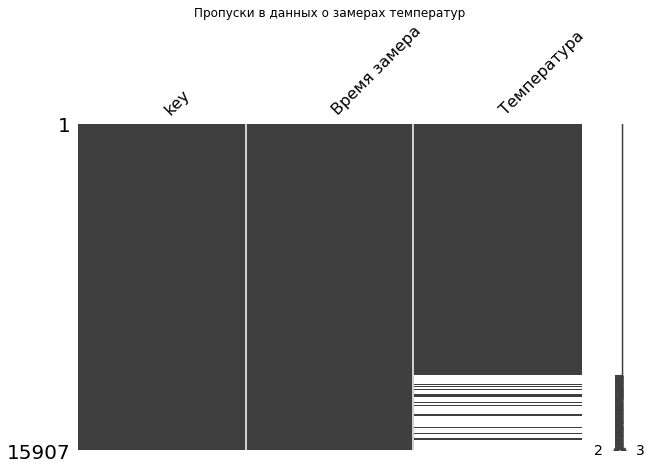

In [15]:
msgn.matrix(explorer.df_temp, figsize=(10, 6))
_ = plt.title('Пропуски в данных о замерах температур')

4. Тем не менее, поскольку это не противоречило принятому решению - данные были объединены без каких либо предпочтений по способу объединения, все признаки собраны, согласно изначальному решению, в общий котел, без предпочтений по объединяющему признаку (ключи партий, даты), исходя из того, что целевым признаком является каждая измеренная температура. Был собран датасет с 33 столбцами-признаками и 11705 строками-наблюдениями, приличный по размеру, но компромиссный, с шумными данными и дублирующими друг друга признаками.
5. Поскольку сущностное содержание признаков неизвестно, неизвестны единицы измерения, принимая во внимание особенности линейной регрессии - сравнительно больший признак важнее других - данные были приведены к одному масштабу, в том числе, в надежде на то, что масштабирование нивелирует проблемы в данных в такой степени, что обученная модель сразу же даст хороший результат.
6. Результаты модели - на валидационной выборке модель допустила среднюю абсолютную ошибку в 13.77 градуса, на тестовой выборке - 13.61 градусов. С учетом того, что температуры, которые мы предсказывали колеблются между 1500 и 1700 градусов средняя ошибка около 14 градусов кажется небольшой. Но даже на точечной диаграмме видно, что модель много раз промахнулась.

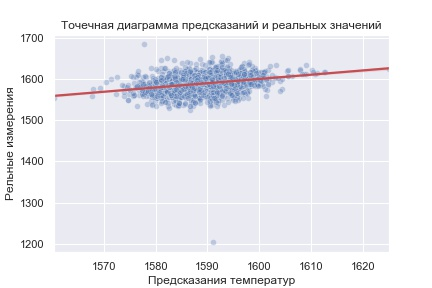

7. Визуально, разница между реальными и предсказанными выглядит совсем плохо:

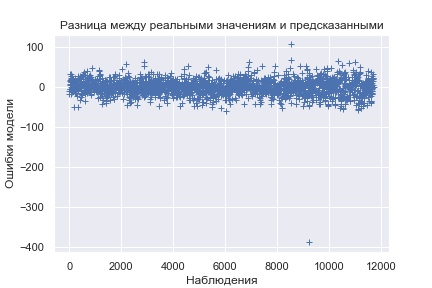

6. Если ответить на каждый из случаев константным значением, например, медианой, то средняя абсолютная ошибка составит 14.7, что разнится с предсказанием модели на 1 градус. Так что первый полученный результат дал четкий ответ - решение оказалось неверным, стратегия получения признаков ошибочной, а обученная модель очень быстро (менее 1 секунды) ничего не предсказывает.
7. Тим лид установил формальные критерии выполнения задачи: средняя абсолютная ошибка в диапазоне от 7.6 и ниже, а таже указал на целевой признак: последняя измеренная в партии температура.
8. Наивное решение не принесло результатов, поскольку имеющиеся признаки недостаточны для предсказания каждой из температур с разумной степенью точности, но определение целевого признака как последнее измерение температуры в каждой из партий "высвобождает" предшествующие целевому признаку замеры температуры в каждом конкретном случае. Как следствие, стало возможным получить в качестве признаков исторические данные о замерах температуры предшествующих целевому признаку.
9. В долгосрочной перспективе решение задачи предсказания температуры с точки зрения временного ряда может повлечь проблемы с адекватностью предсказаний в различных условиях производства, потребует исключительной осторожности и калибровки в зависимости от условий производства, но он является адекватным и достаточно простым в реализации при заданных условиях задачи и может принести результат в кратко-среднесрочном периоде.
10. Поэтому было сформулировано новое решение задачи - делать предсказания, в первую очередь, в зависимости от ранее замеренной температуры, исходя из того, что плавление стали представляет собой непрерывный цикличный процесс.
11. Принятое решение повлекло за собой дополнительные ограничительные условия для создания признаков и, фактически, собственной формулировкой детерминировало оптимальный способ объединения данных по ключу-номеру партий:
    - ограничения связаны с самим целевым признаком - общее число партий продукта в данных о целевом признаке составляет 3216. Это максимально возможное количество наблюдений о целевом признаке.
    - в разных данных отсутствуют различные партии продукта, что неизбежно естественным путем сократит количество наблюдений,
    - данные об электродах требуют агрегации по ключу и, как следствие, необходимость избрать способ агрегации для данных о мощности,
    - для создания дополнительных признаков из "исторических" данных о замерах температуры придется избавится от неизбежных пропусков там, где данных не хватит,
    - даже после объединения, принимая во внимание все ограничения, может возникнуть дополнительный фактор в виде недостаточности наблюдений для обучение моделей и, как следствие, необходимость сохранять выбросы.
12. Для целей объединения данные об электродах сгруппированы по ключу, в качестве агрегирующей функции для мощности и времени нагрева избрали среднее значение, поскольку мы не знаем единиц измерения в случае с мощностью. Таким образом, получили дополнительный вспомогательный признак, носящий характер коэффициента. Кроме того, в качестве дополнительного признака была подсчитана сообщенная в результате нагрева энергия. К положительной стороне группировки можно отнести возможность без дублирования признаков присоединить к данных об электродах данные о продувке газом, сыпучих материалов и проволоки. На данном этапе это привело к уменьшению числа наблюдений до 3214 строк.
13. В свою очередь, в данных с измерениями температуры созданы дополнительные признаки с предшествующими целевой температурами (лаг в три шага, чтобы сохранить больше наблюдений), абсолютная разница в температуре между первым и последним измерением предшествующим целевому измерению, и среднее данных температур. После этого, данные были сгруппированы по ключу-партии: получили 2478 наблюдений.
14. Наконец, оба промежуточных датасета - с данными о нагреве, сыпучих материалах и проволоке и данными об измерениях температуры были объединены в один и готовы к обучению моделей: 36 свободных признаков, 1 целевой признак - температура, 1 технический столбец - ключ партии. Поскольку итоговый размер датасета содержит в себе 2330 наблюдений из максимально возможных 3216 (72 %), то для сохранения данных пришлось пойти на еще один компромисс и проигнорировать выбросы. Однако набор из 36 признаков позволит экспериментировать с их комбинациями для достижения лучшего качества и выбора оптимального набора данных.
15. Для обучения избраны три разные по типу модели - линейную регрессию, регрессор LightGBM и нейросеть MLPRegressor. До обучения были сформирован ожидания: лучшее время и отличная метрика у линейной регрессии; метрика лучше или такая же как у линейной регрессии у LightGBM, но время обучения в десять раз дольше; MLPRegressor - плохое качество и низкая скорость обучения. Одновременно подбирали лучшие параметры с помощью поиска по сетке. 
16. С учетом принятого решения были созданы 8 комбинаций признаков для обучения моделей:
    - признаки только из временного лага,
    - признаки из временного лага и полученные из данных о времени замера температуры,
    - признаки без данных о сыпучих материалах и проволоки,
    - признаки без временного лага, но с данными о средней температуре и разнице в первой и предпоследней температуре,
    - признаки без подробных значений о сыпучих материалах и проволоки (с агрегированными столбцами),
    - признаки без данных о средней температуре и разнице между первой и предпоследней температурой
    - признаки без временного лага, без средней температуры, без разницы в первой и предпоследней температуре,
    - все признаки.
17. Второй раунд обучения принес желаемый результат: лучший результат на валидационной выборке показала линейная регрессия, обученная на признаках без значений о сыпучих материалах и проволоки - МАЕ 4.368, на тестовой выборке модель показала ошибку в 4.301. 

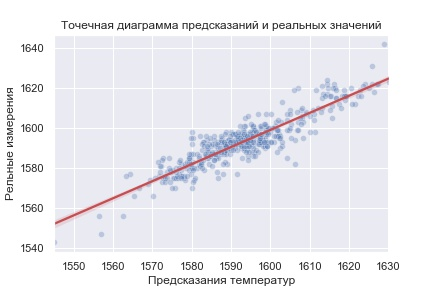

18. Визуально - ошибок совсем мало и они несравнимо меньше, чем при первой попытке:

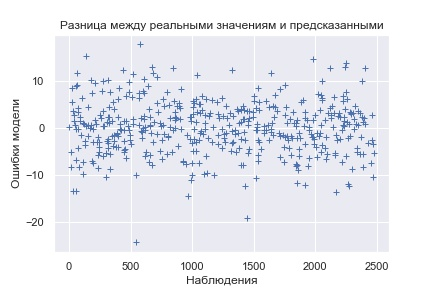

[В оглавление](#TOC)

### 3) Результат

1. Получили девять стабильных моделей - пять линейных регрессии, три LGBMRegressor, одну нейронную сеть со средней абсолютной ошибкой на валидационной выборке и тестовой меньше 5 градусов(МАЕ).
2. В списке лучших моделей 6 различных вариантов признаков из 8 возможных: модели, которые обучались на признаках без временного лага, но с данными о средней температуре и разнице в первой и предпоследней температуре (features_no_lag), а также на признаках без временного лага, без средней температуры, без разницы в первой и предпоследней температуре (features_no_time) дали большую ошибку.
3. Лучший результат на валидационной и тестовой выборке показала линейная регрессия, обученная на признаках без подробных значений о сыпучих материалах и проволоки (с аггрегированными столбцами), которая в среднем ошибается менее, чем на 5 градусов:
    - МАЕ на валидационной выборке - 4.37
    - МАЕ на тестовой выборке - 4.301

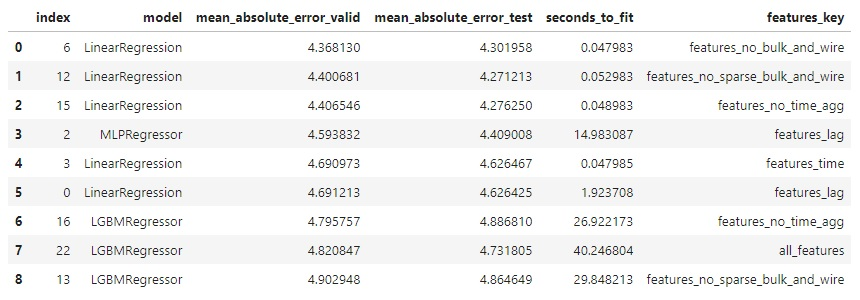

[В оглавление](#TOC)

### 4) Заключение

1. Для обучения были избраны три модели - линейная регрессия, регрессор LightGBM и нейросеть MLPRegressor.
2. Было обучено 24 модели с разными комбинациями признаков, получены 9 стабильных моделей для предсказания температуры. 
3. Зависимость функции температуры от набора признаков - T(X) - установлена c приемлемой точностью: значение средней абсолютной ошибки (mean absolute error, МАЕ) менее 6.

[В оглавление](#TOC)